## Supreme Court Voting Patterns

Here we will explore how the justices have voted over the past several years. 
Data is provided by http://scdb.wustl.edu/data.php

In [102]:
import os
import pathlib as path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx

datapath = "/Users/gordonpetty/Documents/SCDB_2024_01_justiceCentered_Docket.csv"

df = pd.read_csv(path.Path(datapath))
df.head()

,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,sctCite,ledCite,lexisCite,...,majVotes,minVotes,justice,justiceName,vote,opinion,direction,majority,firstAgreement,secondAgreement
0,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01-01,11/18/46,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,...,8,1,86,HHBurton,2.0,1.0,1.0,1.0,NaN,NaN
1,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01-02,11/18/46,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,...,8,1,84,RHJackson,1.0,1.0,2.0,2.0,NaN,NaN
2,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01-03,11/18/46,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,...,8,1,81,WODouglas,1.0,1.0,2.0,2.0,NaN,NaN
3,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01-04,11/18/46,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,...,8,1,80,FFrankfurter,4.0,2.0,2.0,2.0,NaN,NaN
4,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01-05,11/18/46,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,...,8,1,79,SFReed,1.0,1.0,2.0,2.0,NaN,NaN


The "Vote" column indicates how a justice voted on a given case:

1	voted with majority or plurality

2	dissent

3	regular concurrence

4	special concurrence

5	judgment of the Court

6	dissent from a denial or dismissal of certiorari , or dissent from summary affirmation of an appeal

7	jurisdictional dissent

8	justice participated in an equally divided vote

Cases where a justice did not vote are coded as "nan" (empty cells in the csv)

For our purposes we will lump all concurrences together and all dissents together. I.E. anyone dissenting is considered voting with every other dissenting justice, and every concurrence is considered a vote with the majority. 

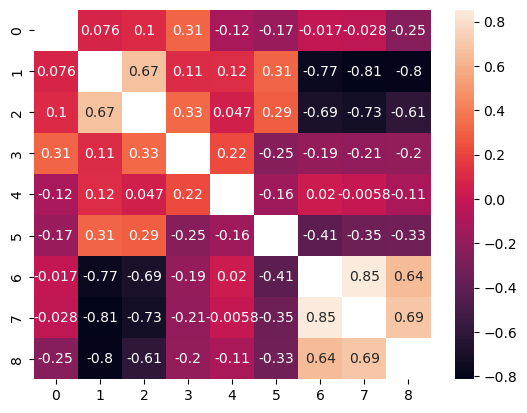

In [100]:
# Trim down to just the 2023 term
df_2023 = df.loc[df['term'] == 2023]
# Remove all cases that were unanimous, i.e. number of dissenting votes == 0
df_2023 = df_2023.loc[df_2023['minVotes']!=0]
# Each vote is uniquely indexed by a "Docket ID"
docketIds = df_2023['docketId'].unique()
# For each justice, get a vector of their votes, where 1's indicate voting with the majority and 0's indicate dissents

justiceOrder = ['JGRoberts', 'CThomas', 'SAAlito', 'BMKavanaugh', 'ACBarrett',
       'NMGorsuch', 'SSotomayor','EKagan','KBJackson']

voteMat = np.zeros([len(docketIds),len(justiceOrder)])
for i in range(len(justiceOrder)):
    j = justiceOrder[i]
    v = df_2023.loc[df_2023['justiceName']==j,'vote']
    v[v.isin([1,3,4,5])] = 1
    v[v.isin([2,7])] = -1
    v = v.fillna(0)
    v=v.to_numpy()
    voteMat[:,i] = v

corrMat = np.corrcoef(voteMat.T)
np.fill_diagonal(corrMat,'nan')
sns.heatmap(corrMat,annot=True)
plt.show()

In [118]:
# Run k-means on the vote matrix, grouping justices by their votes
from sklearn.cluster import KMeans
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(voteMat.T)
(kmeans.labels_)
groupDict = {i:j for i,j in zip(justiceOrder,kmeans.labels_)}
groupDict

{'JGRoberts': 2,
 'CThomas': 1,
 'SAAlito': 1,
 'BMKavanaugh': 2,
 'ACBarrett': 2,
 'NMGorsuch': 1,
 'SSotomayor': 0,
 'EKagan': 0,
 'KBJackson': 0}

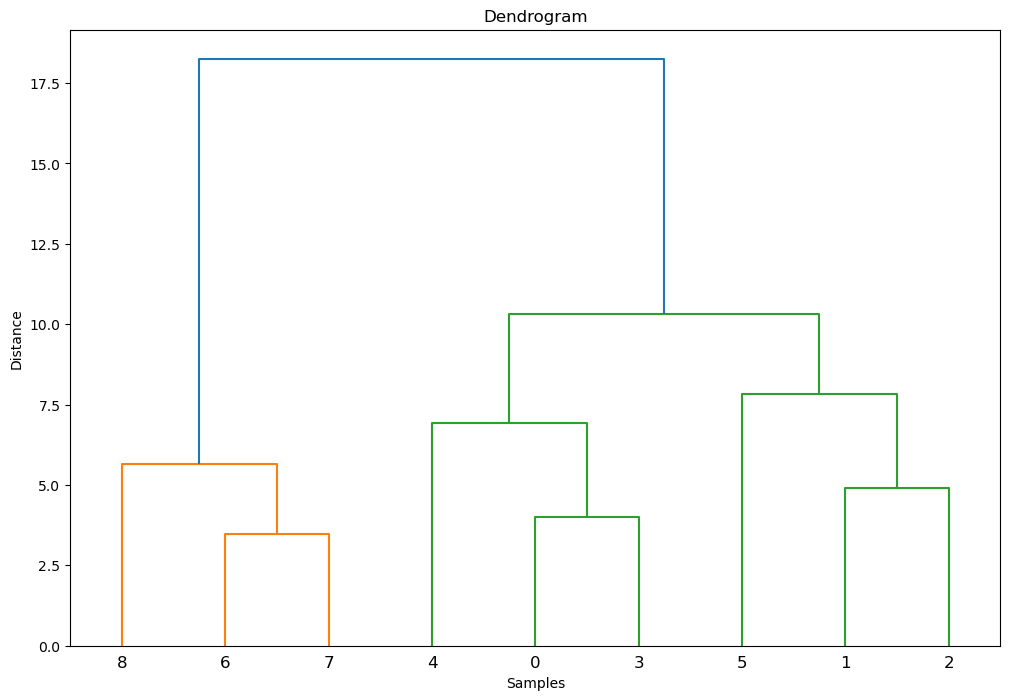

array([7, 6, 8, 5, 4, 3, 1, 2, 0])

In [136]:
# Hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
aggClust = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
aggClust.fit_predict(voteMat.T)
aggClust.labels_
linkage_matrix = linkage(voteMat.T, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()
aggClust.labels_

[[ 6.          7.          3.46410162  2.        ]
 [ 0.          3.          4.          2.        ]
 [ 1.          2.          4.89897949  2.        ]
 [ 8.          9.          5.65685425  3.        ]
 [ 4.         10.          6.92820323  3.        ]
 [ 5.         11.          7.83156008  3.        ]
 [13.         14.         10.32795559  6.        ]
 [12.         15.         18.24524291  9.        ]]


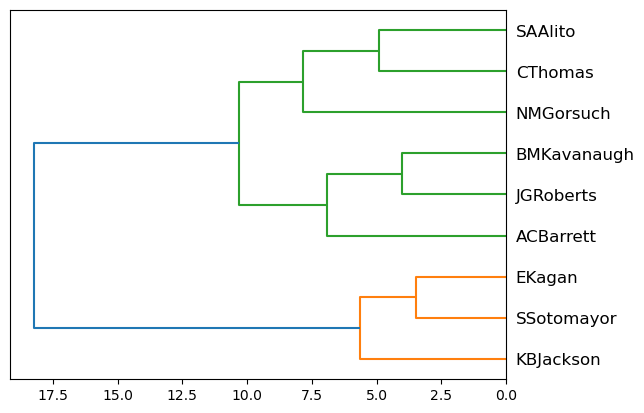

In [143]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    print(linkage_matrix)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(voteMat.T)
plot_dendrogram(model,labels=justiceOrder,orientation='left')


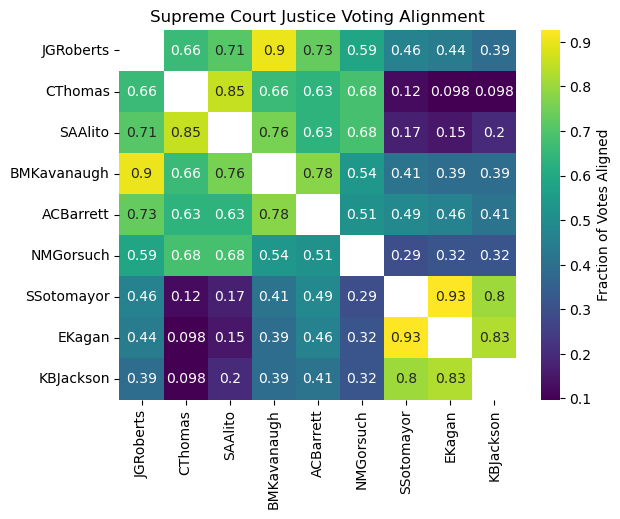

In [2]:
# The Vote column indicates how a justice voted on the case:





# Iterate over unique cases. Each vote is uniquely indexed by a "Docket ID"
docketIds = df_2023['docketId'].unique()
# For each case, create a matrix depicting which justices voted together
voteMatrix = np.zeros([9,9])
# Define an order for the justices, in case they are selected out of order:

for case in docketIds:
    currdata = df_2023[df_2023['docketId']==case]
    currdata.set_index('justiceName',inplace=True)
    votes = currdata.loc[justiceOrder,'vote']
    maj_votes = votes.isin([1,3,4,5]).to_numpy()
    dis_votes = votes.isin([2,7]).to_numpy()
    matrix = np.outer(maj_votes,maj_votes) + np.outer(dis_votes,dis_votes)
    voteMatrix += matrix


np.fill_diagonal(voteMatrix,'nan')
# Convert from counts to fraction of cases
n_cases = len(docketIds);
voteMatrix = voteMatrix / n_cases
#print(voteMatrix)
sns.heatmap(voteMatrix,cmap='viridis',yticklabels=justiceOrder,xticklabels=justiceOrder,
           cbar_kws={'label': 'Fraction of Votes Aligned'},annot=True)
plt.title('Supreme Court Justice Voting Alignment')
plt.show()

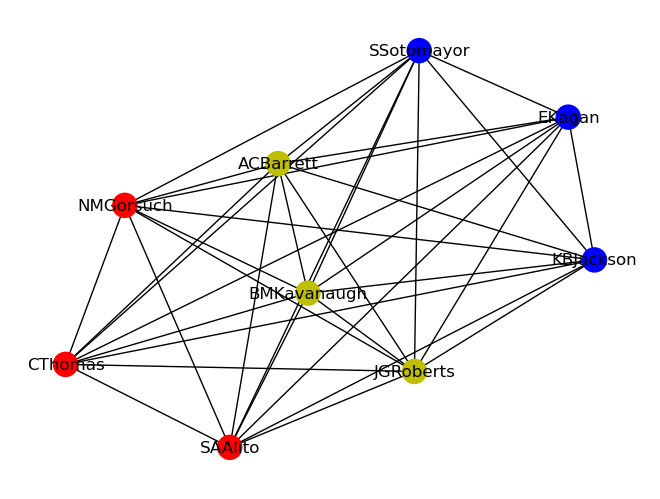

In [51]:
# Create a Graph object and use our matrix to populate it:
G = nx.Graph()
num_nodes = voteMatrix.shape[0]
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):  # Only iterate over upper triangle
        weight = voteMatrix[i,j]
        
        G.add_edge(i, j, weight=weight)

# Add labels to the nodes:
node_labels = {i:j for i,j in zip(range(9),justiceOrder)}
node_colors = ['y','r','r','y','y','r','b','b','b']
G = nx.relabel_nodes(G, node_labels)
pos = nx.spring_layout(G,weight='weight',iterations=50)
nx.draw(G, pos,with_labels=True,node_color=node_colors)
plt.show()

In [4]:
np.nanpercentile(voteMatrix,[10,20,30,40,50])


array([0.14878049, 0.31707317, 0.3902439 , 0.43902439, 0.5       ])